In [79]:
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from bertopic import BERTopic
from bertopic.representation import BaseRepresentation
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN

dataset = "dreamachine"
condition = "HS"

print(f"Current working directory: {os.getcwd()}")
BOX_DIR = os.path.join(os.path.expanduser("~"), "Library", "CloudStorage", "Box-Box", "TMDATA")
print(f"Retrieving data from BOX, locally stored at: {BOX_DIR}")
DATA_DIR = os.path.join(BOX_DIR, dataset)
print(f"Data directory: {DATA_DIR}")



Current working directory: /Users/rb666/Projects/MOSAIC
Retrieving data from BOX, locally stored at: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA
Data directory: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/dreamachine


[nltk_data] Downloading package punkt to /Users/rb666/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/rb666/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [80]:

# load only the 'reflection_answer' column from each CSV file for the selected condition (HS or DL in the case of dreamachine dataset)
reflection = pd.read_csv(os.path.join(DATA_DIR, f'{condition}_reflections_APIcleaned.csv'), usecols=['cleaned_reflection']).dropna()
# dl_reflection = pd.read_csv(os.path.join(DATA_DIR, 'DL_reflections_APIcleaned.csv'), usecols=['cleaned_reflection']).dropna()

print(f"{condition} reflection_answer shape:", reflection.shape)
# print("DL reflection_answer shape:", dl_reflection.shape)

HS reflection_answer shape: (333, 1)


In [81]:
reflection

,cleaned_reflection
0,Intense chaos. And then my mind checked out an...
1,Good stuff.
2,A pattern of red and white lights that flashed...
3,I went back to many hard and mostly beautiful ...
4,Hello.
...,...
331,Changing temperature of my body with the light...
332,Pleasure & intrigue.
333,Travelling through space.
334,I thought a lot about Rand's journey into Rhui...


In [82]:

# ----------------------------------------
reports = reflection['cleaned_reflection'].tolist()
print(f"Loaded {len(reports)} documents for BERTopic modeling.")
# ----------------------------------------

# ----------------------------------------

# Divide each report into sentences
reports_sentences = [nltk.sent_tokenize(report) for report in reports]

sentences = [sentence for report in reports_sentences for sentence in report]
print(f"Total number of sentences across all reports: {len(sentences)}")
# ----------------------------------------

Loaded 333 documents for BERTopic modeling.
Total number of sentences across all reports: 730


In [83]:
sentences

['Intense chaos.',
 'And then my mind checked out and my subconscious took over and started talking.',
 "What I imagine it's like looking back on life before you die.",
 'Good stuff.',
 'A pattern of red and white lights that flashed and became more intense when the lights flashed intensely.',
 'I also felt sleep for a bit and I was thinking of my partner, who I could visualize.',
 'I went back to many hard and mostly beautiful memories without prompting them at all.',
 'Hello.',
 'Hope as a color.',
 'Dreaming while awake—flashes of random places I have been.',
 "Maybe this is what it's like to be dead.",
 'Being: immersed; calm; and thrilled.',
 'Life after retirement.',
 'I dreamt myself as a harbinger of the new planet, shaping the world with life and equity.',
 'I wish to belong there with someone I really loved and missed...',
 'Relaxation, calm, and curiosity.',
 'Personally, it was hard for me to find peace with the intensity of the bright light.',
 "My eyes wouldn't stop water

In [84]:
# filter sentences by min length
min_word_count = 3
sentences = [s for s in sentences if len(s.split()) >= min_word_count]
print(f"Total number of sentences after filtering by length: {len(sentences)}")

docs = sentences

Total number of sentences after filtering by length: 676


In [85]:
sentences

['And then my mind checked out and my subconscious took over and started talking.',
 "What I imagine it's like looking back on life before you die.",
 'A pattern of red and white lights that flashed and became more intense when the lights flashed intensely.',
 'I also felt sleep for a bit and I was thinking of my partner, who I could visualize.',
 'I went back to many hard and mostly beautiful memories without prompting them at all.',
 'Hope as a color.',
 'Dreaming while awake—flashes of random places I have been.',
 "Maybe this is what it's like to be dead.",
 'Being: immersed; calm; and thrilled.',
 'Life after retirement.',
 'I dreamt myself as a harbinger of the new planet, shaping the world with life and equity.',
 'I wish to belong there with someone I really loved and missed...',
 'Relaxation, calm, and curiosity.',
 'Personally, it was hard for me to find peace with the intensity of the bright light.',
 "My eyes wouldn't stop watering, so that kept my mind occupied.",
 'Still 

In [86]:
from huggingface_hub import hf_hub_download  # For loading the model instance from Hugging Face
import os  # For creating system directories
from llama_cpp import Llama  # LLM Wrapper
from bertopic.representation import KeyBERTInspired, LlamaCPP  # Representation Comparison
from sentence_transformers import SentenceTransformer  # Embedding Model Wrapper
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic  # For topic modeling with BERTopic
import PIL  # For image processing
import numpy as np  # For numerical computations
import requests  # For making HTTP requests
import datamapplot  # For data visualization
import re  # For regular expressions

In [87]:
model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
os.makedirs('model', exist_ok=True)
# path = "model"


# Downloading the model from repo
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename) #, cache_dir=path)


# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, 
            n_gpu_layers=-1, #offload all possible layers of the model to the GPU
            n_ctx=4096, 
            stop=["Q:", "\n"],
            verbose=False)

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf

In [88]:
prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]


The topic is described by the following keywords: '[KEYWORDS]'.


Based on the above information, give a short label of the topic of at most 5 words.
A:
"""


representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm, prompt=prompt),
}


# Pre-calculate embeddings
# embedding_model = SentenceTransformer("BAAI/bge-small-en-v1.5")
embedding_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)


# #------------------------------------------------------------
# #parameters for HS:
# # Pre-reduce embeddings for visualization purposes
# reduced_embeddings = UMAP(n_neighbors=20, n_components=2, min_dist=0.025, metric='cosine', random_state=42).fit_transform(embeddings)

# vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')

# # Define sub-models
# umap_model = UMAP(n_neighbors=20, n_components=15, min_dist=0.025, metric='cosine', random_state=42)
# hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)



#------------------------------------------------------------
#parameters for DL:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=25, n_components=2, min_dist=0.025, metric='cosine', random_state=42).fit_transform(embeddings)

vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')

# Define sub-models
umap_model = UMAP(n_neighbors=25, n_components=18, min_dist=0.025, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

In [89]:
topic_model = BERTopic(
 # Sub-models
 embedding_model=embedding_model,
 umap_model=umap_model,
 hdbscan_model=hdbscan_model,
 representation_model=representation_model,
 vectorizer_model=vectorizer,
#  nr_topics="auto",  # Automatically determine the number of topics
nr_topics=None,
 # Hyperparameters
 top_n_words=10,
 verbose=True
)


# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)


# Show topics
topic_model.get_topic_info()

2025-09-12 18:21:35,486 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-12 18:21:36,864 - BERTopic - Dimensionality - Completed ✓
2025-09-12 18:21:36,865 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-12 18:21:36,879 - BERTopic - Cluster - Completed ✓
2025-09-12 18:21:36,880 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 18/18 [00:17<00:00,  1.05it/s]
2025-09-12 18:21:55,665 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,202,-1_felt_like_felt like_experience,"[felt, like, felt like, experience, body, feel...","[felt, felt like, kaleidoscope, sensation, bra...","[""Vivid Imagery of Spiritual Journey"", , , , ,...","[Then, all of a sudden, I felt like I was dise..."
1,0,164,0_saw_shapes_like_patterns,"[saw, shapes, like, patterns, colours, geometr...","[colours patterns, fractals, kaleidoscopes, pa...","[Vivid Geometric Patterned Vision, , , , , , ,...",[A couple of times the small geometric shapes ...
2,1,64,1_peace_calm_sense_memories,"[peace, calm, sense, memories, joy, relaxation...","[peacefulness, peace tranquility, peaceful exp...","[""Experiencing Peaceful Life Moments"", , , , ,...","[A great sense of calm and belonging., An incr..."
3,2,39,2_felt_sense_experience_euphoric,"[felt, sense, experience, euphoric, emotional,...","[felt euphoric, felt relaxed, sense euphoria, ...","[""Emotional and Spiritual Experiences"", , , , ...","[I felt very peaceful, euphoric, with a sense ..."
4,3,33,3_space_felt_like_body,"[space, felt, like, body, time, travelling, fe...","[suddenly felt, body felt, felt body, universe...","[""Out-of-Body Space Travel Experiences"", , , ,...",[Then I began to float through a tunnel filled...
5,4,30,4_experience_overall_amazing experience_amazing,"[experience, overall, amazing experience, amaz...","[amazing experience, awesome experience, wonde...","[""Positive and Enjoyable Life Experience"", , ,...","[Overall, it was an amazing experience., Lovel..."
6,5,28,5_thought_asleep_thinking_mind,"[thought, asleep, thinking, mind, thoughts, dr...","[momentary visions, interrupting dreamlike, vi...","[""Exploration of the Subconscious Mind"", , , ,...","[I was put in a dreamlike, semiconscious state..."
7,6,24,6_music_sound_louder_louder music,"[music, sound, louder, louder music, enjoyed, ...","[music intense, music kaleidoscopic, music vis...","[""Exploring Music and Sensory Experience"", , ,...","[I became the music and the music became me, a..."
8,7,13,7_colours_colors_colours brain_art,"[colours, colors, colours brain, art, brain, e...","[visuals experiences, colours yearning, lots v...","[""Exploring the Mind's Colorful Landscape"", , ...",[The experience felt like a new form of art in...
9,8,13,8_health_health safety_necessary_safety,"[health, health safety, necessary, safety, adv...","[felt overwhelming, adventure departure, theme...","[""Health and Safety in Storytelling"", , , , , ...",[I wanted to engage more; it annoyed me when i...


In [90]:
topic_model.visualize_documents(docs, 
                                reduced_embeddings=reduced_embeddings,
                                hide_annotations=True, 
                                hide_document_hover=False, 
                                custom_labels=True)

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `llama-3-8b-instruct`'}>)

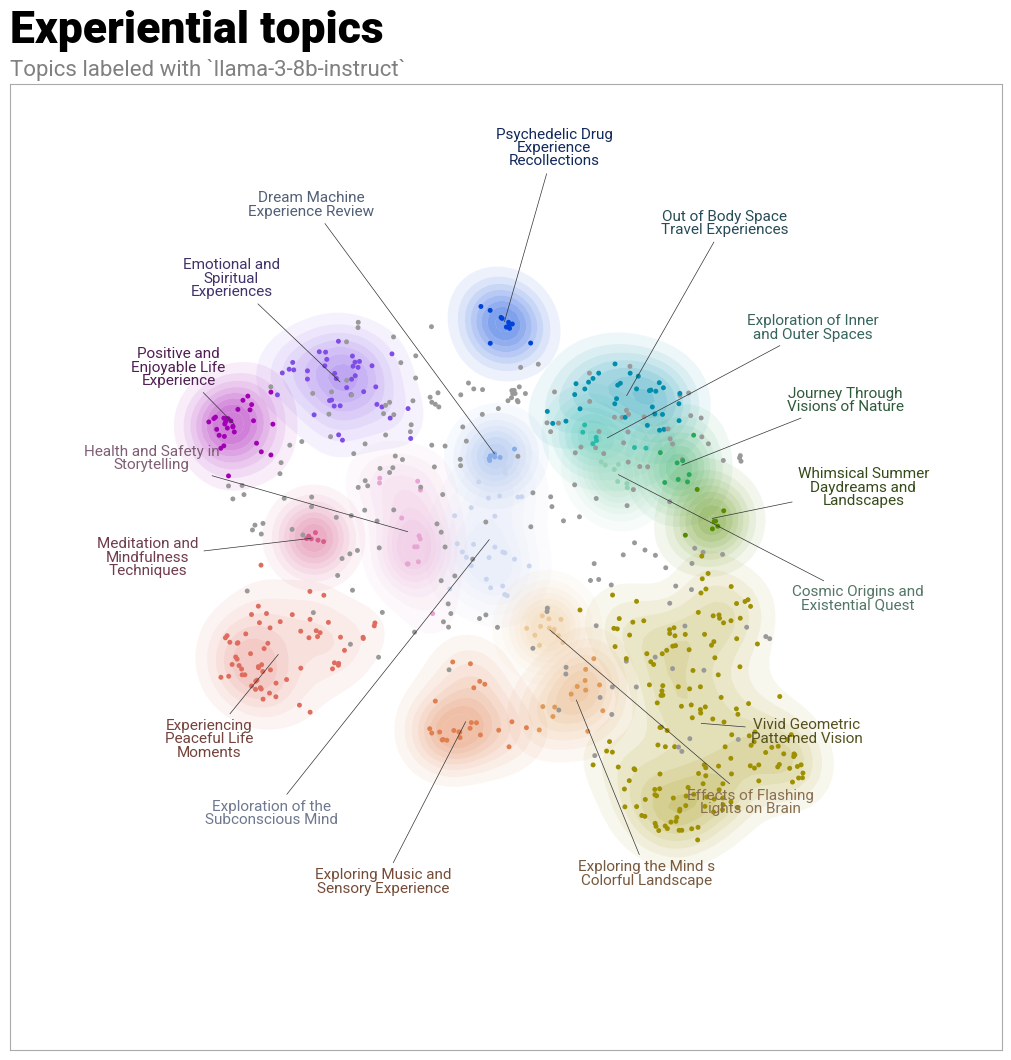

In [91]:
# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]


# Run the visualization
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=11,
   title="Experiential topics",
   sub_title="Topics labeled with `llama-3-8b-instruct`",
   label_wrap_width=20
)

In [92]:

hierarchy_vis = topic_model.visualize_hierarchy(custom_labels=True, color_threshold=.9)
hierarchy_vis